# Titanic

To most, the Titanic may evokes imagery of a grand ship, a newspaper headline,
or maybe the iconic picture of Leo & Kate on the bow of the ship. To data
scientists, the Titanic often reminds us of our first dataset, a *real* dataset,
requiring vast amounts of cleaning, preprocessing, transformation, and
hyperparameter tuning.

Nevertheless, the Titanic dataset is a great place to start with data science
projects. It is a great place to start, covering a great variety of topics.

## Setup

### Download Data

In [2]:
import shutil
from pathlib import Path
import kagglehub

In [3]:
def download_dataset(name: str) -> list[Path]:
    out_path = kagglehub.dataset_download(name)
    files = [path for path in Path(out_path).iterdir() if path.is_file()]
    if not files:
        raise FileNotFoundError(f"Download directory '{out_path}' is empty.")

    dest_files = [Path.cwd() / file.name for file in files]
    for src, dest in zip(files, dest_files):
        shutil.copy2(src, dest)
    
    return dest_files


files = download_dataset('yasserh/titanic-dataset')
files = [f for f in Path.cwd().iterdir() if f.suffix == '.csv']
print(f'Downloaded {len(files)} file(s):', end='\n\n')
print('\n'.join(file.name for file in files))

Downloaded 1 file(s):

Titanic-Dataset.csv


### Define Workflow

Before we start, let's define the scope of our workflow. I'm taking the steps
from the framework CRISP-DM (Cross-Industry Standard Process for Data Mining).
Data Science PM has a useful overview of this framework on their [website][1].

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

<!-- References -->

[1]: https://www.datascience-pm.com/crisp-dm-2/

## 1. Business Understanding

### Business Objectives

Typically, we'll want to thoroughly understand the business side of things
before embarking on an analysis. This involves a lot of discussion with
stakeholders--the ones who feel the most impact from the problem at hand.

Perhaps we need an understanding of what went wrong on the Titanic in order to
prevent future disasters. Or, maybe we want to analyze the most impactful
features of passengers in their survival so as to determine the effect of
society norms in the early 20th century on a passenger surviving any kind of
disaster.

Regardless of the business case, we're looking to understand survival of
Titanic passengers and create a model to predict which passengers will survive.

### Assess the Situation

Here is where we would need to evaluate what resources we have available. If
our model was computationally intensive, what resources does our company have
with cloud computing? Are there other metadata or supplemental datasets that
may be useful here?

For our purpose, we simply have the dataset provided to us by Kaggle.
As we get further into the analysis, we can evaluate risks/contingencies based
on the cleanliness of the data.

### Determine the Goals

> *In short, what does success look like?*

Personally, I would love to see a model that can predict (with excellent
accuracy) which passengers will survive the Titanic. I anticipate that the
bare features alone won't cut it, so a successful model will likely have
well-engineered features that make use of the raw data. Finally, a successful
project would be one that considers multiple models, using cross-validation,
and implements the most successful one.

Summarizing these goals, we want to:

1. Create a machine learning model to predict which passengers survive
2. Have excellent performance (to be clarified later)
3. Develop well-engineered, meaningful features
4. Utilize cross-validation to select the best-performing model

### Formulate a Project Plan

What kind of technologies do we want to use, and how will we implement them?

We'll need to revisit this as we get further understanding of the data, but
initially, we could make use of:

- Logistic Regression
- Naive-Bayes
- k-Nearest Neighbors
- Decision Tree
- Random Forest
- Gradient-Boosted Trees
- Ada Boost
- Support Vector Machines

Much of these are quickly available in the Scikit-Learn library. In addition,
this library also provides tools for:

- Train-Test splits
- K-fold cross-validation
- Stratified K-Fold cross-validation
- Grid search CV
- Accuracy metrics

## 2. Data Understanding

This stage is more commonly referred to as EDA, or exploratory data analysis.
We want to import our data and understand its structure, what problems
we need to fix, and any other factors that may affect our workflow.

### Load Data

In [4]:
# Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns

In [5]:
assert len(files) == 1
file = files[0]
assert file.suffix.lower() == '.csv'
df = pd.read_csv(file)
print('Loaded data into variable `df`')

Loaded data into variable `df`


### Describe our Data

Here, we want to understand some high-level characteristics of our data, namely:

1. Data preview (i.e., the head)
2. Data types
3. Descriptive statistics
4. Null value distribution

In [6]:
# Display first 10 rows
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


> **Notes:**
>
> - `PassengerId` looks like a simple incrementing ID; this should be set as
>   the index.
> - `Survived` is our target, a one-hot variable with 1 = "Survived"
> - `PClass` seems to be a numeric value indicating first, second, or third
>   class rooms on the ship.
> - `Name` doesn't just include first/last name, it also includes title. This
>   may be useful for an engineered feature.
> - `Sex` seems to be only male/female -- this should be converted to a one-hot
>   variable.
> - `Age` - I see one NaN value here. I also notice it got represented as a
>   float -- is there a passenger whose age isn't a whole integer?
> - `SibSp` - Not immediately clear, but this one represents the number of
>   siblings or spouses on the Titanic. I.e., other people in their group of
>   the same age.
> - `Parch` - Like `SibSp`, this isn't immediately clear, but the documentation
>   says this represents the number of parents/children in their group. Both
>   this column and `SibSp` may be useful to quantify the total people in the
>   party's group.
> - `Ticket` - Some of these are integers (ticket number), but some also have
>   information like 'A/5', 'PC', 'STON/O2'. Will need to dig further to
>   understand this field.
> - `Fare` - How much was paid for the ticket. Do higher-paying customers have
>   better chance of survival?
> - `Cabin` - The cabin number. May be useful if `Pclass` isn't available.
> - `Embarked` - S = Southampton, C = Cherbourg, Q = Queenstown. Note that the
>   order here is not arbitrary: This is the order of ports that the Titanic
>   visited.

In [7]:
# Display data types
display(df.dtypes.value_counts().to_frame('# Columns'))
display(df.dtypes.to_frame(name='Type'))

,# Columns
int64,5
object,5
float64,2


,Type
PassengerId,int64
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64


> **Notes:**
>
> As mentioned above, it's interesting that the `Age` field came in as a float.
> It may make more sense to convert this to an integer, unless that partial
> year gives us some kind of information.
>
> Also, while it may be tempting to get rid of the 5 string fields, we can't
> disregard this yet -- we don't have a ton of information to work with, so
> we'll want to extract as much information as possible.

In [8]:
# Describe the data
df.describe().round(2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


> **Notes:**
>
> - `PassengerId` - Irrelevant, as this is just an index.
> - `Survived` - The min/max don't tell us much, but the mean is useful -- 38%
>   of passengers survived, so around 1 in 3.
> - `Pclass` - This is an ordinal field, not numeric, but it does tell us that
>   the average passenger was between class 2 and 3.
> - `Age` - There is a variety of ages on the Titanic, with the typical
>   passenger being about 28-29 years of age, the youngest was 0.42 (5 months)
>   and the eldest was 80 years old. Most passengers (25-75 percentile) were
>   between 20-38 years old.
> - `SibSp` - Most passengers (>50%) didn't have any siblings or spouses. Even
>   the 75% percentile was just 1 other person of their age. The largest group
>   was 8 siblings/spouses (almost certainly 8 siblings).
> - `Parch` - The vast majority (>75%) didn't have any parents or children
>   aboard, but one group had 6 parents/children.
> - `Fare` - On average, passengers paid $32.20 with a *wide* standard deviation
>   of $49.69. Most passengers paid between $8-31, with the wealthiest
>   passenger paying a whopping $512.33 for their fare.

In [9]:
# Understand the null distribution
null_distribution = pd.DataFrame({
    'Null Count': df.isna().sum().map(lambda n: '' if n == 0 else f'{n:,}'),
    '% Null': df.isna().mean().map(lambda p: '' if p == 0 else f'{p:.2%}')
})
null_distribution = null_distribution.loc[null_distribution.iloc[:,0] != '']

null_distribution.T

,Age,Cabin,Embarked
Null Count,177,687,2
% Null,19.87%,77.10%,0.22%


> **Notes:**
>
> Most fields don't have any null values, which is helpful. The most
> problematic field will be Cabin, but from looking at the top 10 rows, it
> doesn't seem like this will be useful. We may just drop this field all
> together.
>
> `Age` is an interesting one: there is a significant amount of nulls here, but
> it may be quite a useful field. We could look at doing a quick predictive
> model based on `Name`, `Fare`, `Embarked`, `SibSp`, and `Parch`. Or, if we
> want something quick, we could do a simple median-value or mean-value
> imputation.
>
> `Embarked` will probably require a quick manual fix here, since it's only
> 2 records.

### Explore the Data

Now for the fun part of EDA--the visuals! Let's try to visualize what our
data looks like. Each cell will be looking to answer a preliminary question
or one raised in the data description step prior to this.

In [10]:
def add_bar_labels(
        ax: Axes,
        fmt: str,
        label_type='center',
        color='white'
) -> None:
    for container in ax.containers:
        ax.bar_label(container, label_type=label_type, fmt=fmt, color=color)
    return

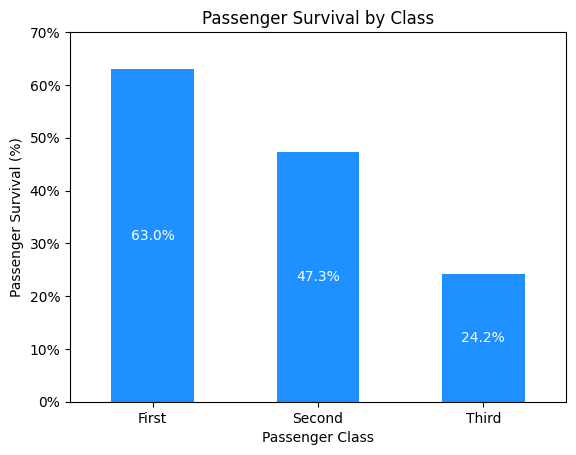

In [11]:
# How did class play a role in survival?
df_class = df.groupby('Pclass', as_index=False)[['Survived']].mean()
ax = df_class.plot(
    kind='bar',
    x='Pclass',
    y='Survived',
    xlabel='Passenger Class',
    ylabel='Passenger Survival (%)',
    rot=0,
    color='dodgerblue',
    legend=False,
    title='Passenger Survival by Class'
)

# X Labels
ax.set_xticks(range(3), ['First', 'Second', 'Third'])

# Y Labels
yticks = ax.get_yticks()
ytick_labels = map('{:.0%}'.format, yticks)
ax.set_yticks(yticks, ytick_labels)

add_bar_labels(ax, fmt='{:.1%}')

# ax.set_title('Passenger Survival by Class', size=14, pad=12)
plt.show()

> **Notes:**
>
> Unsurprisingly, first-class passengers has the best chance of surviving,
> followed by second, then third class.

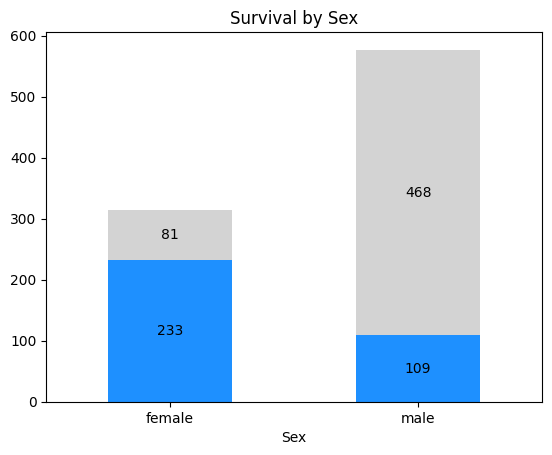

In [12]:
# What was the distribution of sex on the Titanic? How did this affect surival?

# Create pivot-table by sex
df_sex = df.groupby(['Sex', 'Survived'], as_index=False)[['PassengerId']].count()
df_sex = df_sex.pivot(index='Sex', columns='Survived', values='PassengerId')
df_sex.rename(inplace=True, columns=lambda s: ['No', 'Yes'][s])
df_sex.sort_index(inplace=True, axis=1, ascending=False)  # Show 'Yes' first

# Plot data
ax = df_sex.plot(
    kind='bar',
    stacked=True,
    color=['dodgerblue', 'lightgray'],
    legend=False,
    title='Survival by Sex',
    rot=0,
)
add_bar_labels(ax, fmt='{:,.0f}', color='black')
plt.show()

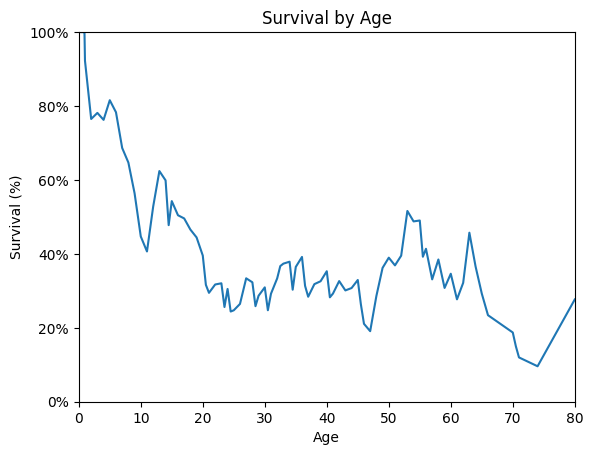

In [13]:
# How does Age play an impact in survival?
df_age = df.groupby('Age', as_index=False)[['Survived']].mean()
df_age['Survived'] = df_age['Survived'].ewm(alpha=0.2).mean()

ax = df_age.plot(
    kind='line',
    x='Age',
    y='Survived',
    legend=False,
    title='Survival by Age',
    xlabel='Age',
    ylabel='Survival (%)',
    xlim=(0, 80),
    ylim=(0, 1),
)

yticks = ax.get_yticks()
ytick_labels = map('{:.0%}'.format, yticks)
ax.set_yticks(yticks, ytick_labels)
plt.show()

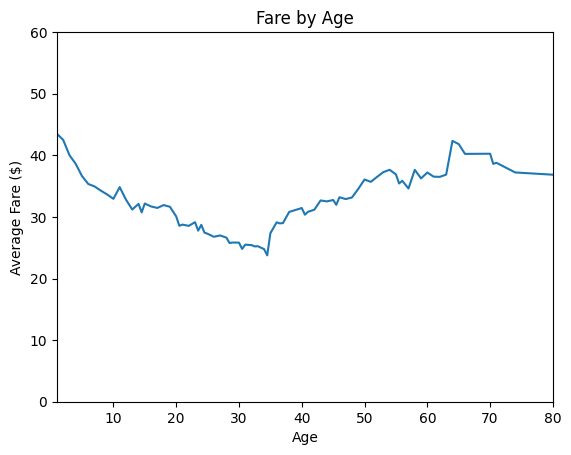

In [173]:
# Did older passengers pay higher fares?

df_age_fare = df.groupby('Age', as_index=False)[['Fare']].mean()
df_age_fare['Fare'] = df_age_fare['Fare'].ewm(alpha=0.05).mean()

ax = df_age_fare.plot(
    kind='line',
    x='Age',
    y='Fare',
    legend=False,
    title='Fare by Age',
    xlabel='Age',
    ylabel='Average Fare ($)',
    xlim=(1, 80),
    ylim=(0, 60),
)

plt.show()

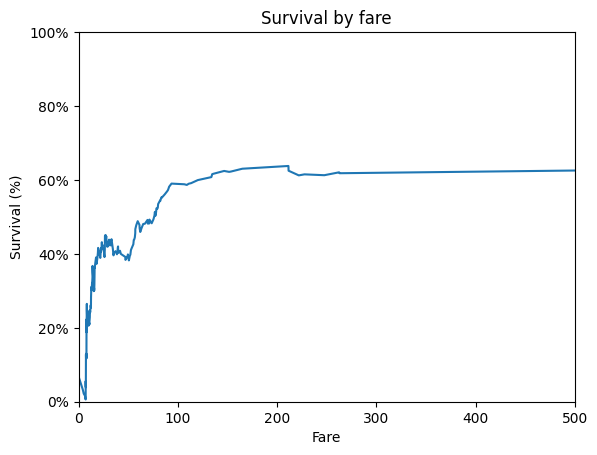

In [46]:
# How does Fare play an impact in survival?
df_fare = df.groupby('Fare', as_index=False)[['Survived']].mean()
df_fare['Survived'] = df_fare['Survived'].ewm(alpha=0.02).mean()

ax = df_fare.plot(
    kind='line',
    x='Fare',
    y='Survived',
    legend=False,
    title='Survival by fare',
    xlabel='Fare',
    ylabel='Survival (%)',
    xlim=(0, 500),
    ylim=(0, 1),
)

yticks = ax.get_yticks()
ytick_labels = map('{:.0%}'.format, yticks)
ax.set_yticks(yticks, ytick_labels)
plt.show()

> **Notes:**
>
> It seems that generally, higher fares meant higher chance of survival, but
> there was a small dip around $30-50 fare, where passnegers that paid around
> $20-30 had a slightly higher chance of survival.

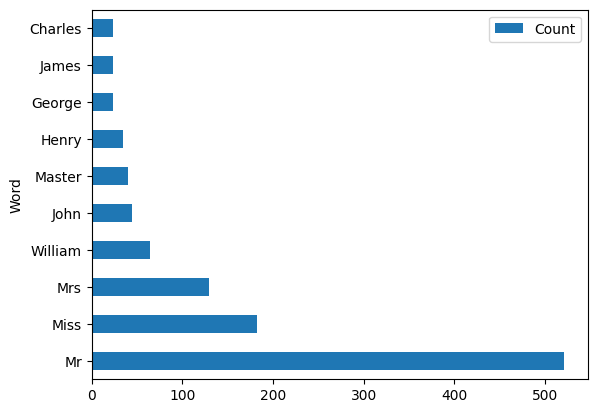

In [14]:
# What are the most common words within "Name"?
is_alnum_or_space = lambda s: s.isalpha() or s == ' '

name_words = str.split(' '.join(
    df['Name'].map(lambda name: ''.join(filter(is_alnum_or_space, name)))
))
word_counts = pd.Series(name_words).value_counts().reset_index()
word_counts.columns = ['Word', 'Count']

ax = word_counts.head(10).plot(
    kind='barh',
    x='Word',
    y='Count',
)

plt.show()

> **Note:**
>
> It doesn't seem like this extracts much information, since common names like
> "William", "John", and "Henry" are captured as common words in names. But,
> we may be able to extract the person's title from the structure of the name:
> nearly every name is structured as "LastName, Title. FirstName (Alt Name)"

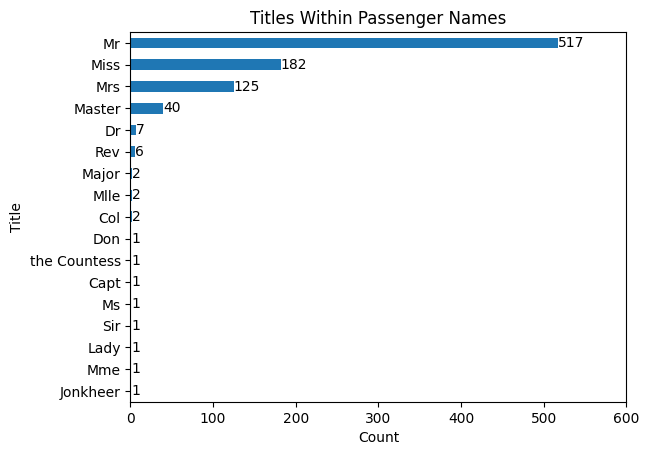

In [15]:
# What are the most common titles?
def extract_name_title(name: str) -> str:
    '''
    Get a person's title out of their name.
    '''
    title_and_firstname = name.split(', ')[1]
    title = title_and_firstname.split('. ')[0]
    return title


name_titles = df['Name'].map(extract_name_title).value_counts().to_frame()
name_titles = name_titles.reset_index()
name_titles.columns = ['Title', 'Count']
name_titles = name_titles.sort_values(by='Count', ascending=True)
ax = name_titles.plot(
    kind='barh',
    x='Title',
    y='Count',
    xlim=(0, 600),
    title='Titles Within Passenger Names',
    legend=False,
    xlabel='Count',
    ylabel='Title',
)
add_bar_labels(ax, fmt='{:.0f}', label_type='edge', color='black')
plt.show()

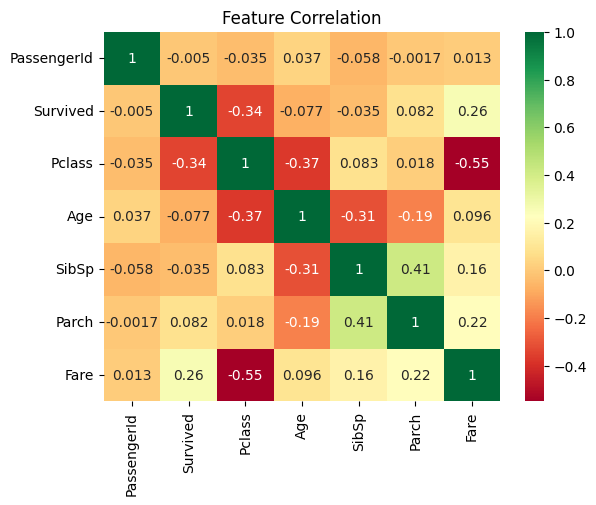

In [19]:
# How strong is the correlation between variables?
ax = sns.heatmap(df.corr(numeric_only=True), cmap='RdYlGn', annot=True)
ax.set_title('Feature Correlation')
plt.show()

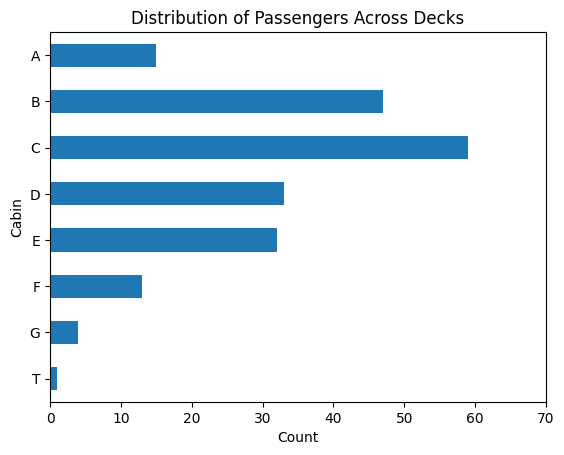

In [228]:
# What were the most common cabins?
df \
    .loc[~df.Cabin.isna(), 'Cabin'] \
    .map(lambda s: s[0]) \
    .value_counts() \
    .sort_index(ascending=False) \
    .reset_index() \
    .plot(
        kind='barh',
        x='Cabin',
        y='count',
        xlim=(0, 70),
        title='Distribution of Passengers Across Decks',
        legend=False,
        xlabel='Count',
        ylabel='Cabin',
    )
add_bar_labels(ax, fmt='{:.0f}', label_type='edge', color='black')

plt.show()

## 3. Data Preparation

Data scientists love to remind each other that roughly 80% of the project
involves data preparation. It's a good rule of thumb, but ultimately is meant
to remind us that we should take extra time to synthesize our data.

Some steps we will take:

1. Clean Data
2. Transform Data

Typically, the Transform step is done in 4 parts: Select, Construct, Integrate,
and Format. For our purposes, we won't need to integrate with any additional
sources, other than some minor details for the Embarked field. Data formatting
is covered pretty thoroughly in the Cleaning stage, so the main step left is
the selection of useful features and construction by means of
transformation/encoding.

### Clean Data

#### Plan

Most of our data is pretty clean for what we need. There are just some null
values that need filling:

| **Column**    | **Strategy**                   |
|:--------------|:-------------------------------|
| `Age`         | Median-Value Fill              |
| `Cabin`       | Default-Value Fill             |
| `Embarked`    | Background Research (2 values) |

In [240]:
df_clean = df.copy()   # Preserve raw data

#### `Age`: Median-Value Fill

To balance simplicity of analysis with as beneficial of an imputation as
possible, we can look to use the median age by `Sex` and `Pclass` to fill the
null values of `Age`.

In [241]:
def median_value_fill(
        df: pd.DataFrame,
        column: str,
        group_by: str | list[str],
) -> pd.DataFrame:
    median_column = f'Median{column}'
    median_values = df \
        .groupby(group_by)[column].median() \
        .reset_index() \
        .rename(columns={column: median_column})
    df = df.merge(median_values)
    df[column] = df[column].fillna(df[median_column])
    df = df.drop(median_column, axis=1)
    return df


df_clean = df_clean.pipe(median_value_fill, 'Age', ['Sex', 'Pclass'])

#### `Cabin`: Default-Value Fill

In [242]:
df_clean['Cabin'] = df_clean.Cabin.fillna('Unknown')

#### `Embarked`: Background Research

In [243]:
df.loc[df.Embarked.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


There are only 2 passengers who are missing the `Embarked` field, both with
first-class tickets:

1. Miss (Rose) Amelie Icard, age 38.
2. Mrs. Martha Evelyn Stone, age 62.

Since there are only 2 passengers without this field, it makes sense to do a
little extra research to find where they embarked from. There is an excellent
site called [Encyclopedia Titanica][1] that has information on many passengers.
It helps that both of these passengers survived to tell their story.

From some quick research, we can see that both [Amelie][2] and [Martha][3]
boarded from Southampton, so we can fill their missing values with 'S'.

Lastly, to help with the interpretation of feature importance, we can change
the `Embarked` field to the full name. This will make it easier to read later,
since 'Southampton' is faster to interpret than just 'S'.

<!-- References -->

[1]: https://www.encyclopedia-titanica.org/
[2]: https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html
[3]: https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html

In [244]:
df_clean['Embarked'] = df_clean.Embarked.fillna('S')

**Aside: A Reminder of the Human Stories Behind the Data**

These 2 passengers were actually in the same group: Amelie boarded the
Titanic as the maid to Martha Evelyn Stone. Encyclopedia Titanica gives a
brief story of their experience when the Titanic struck the iceberg:

<p style="margin: 1rem 2rem; font-style: italic;">
  Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was
  traveling in first class with her maid Amelie Icard. She occupied cabin B-28.
</p>
<p style="margin: 1rem 2rem; font-style: italic;">
  Martha was awake in bed when the Titanic struck the iceberg. She slipped a
  kimono over her night dress, put on her slippers, and went out into the
  corridor and found other people similarly attired. She asked a crew member if
  they had struck an iceberg. "Yes, " he said, "but there is no danger. Go back
  to bed and to sleep." At this time, Mrs Stone could hear the roar of the
  steam blowing off and she asked the officer why they were doing this. He
  told her they had stopped to see what damage there was and that there wasn't
  any danger.
</p>
<p style="margin: 1rem 2rem; font-style: italic;">
  She went back to bed and never received a warning. The roaring steam went on
  for what seemed like forever so she got up and dressed and stepped out into
  the corridor. There, the daughter of the woman across the hall came running
  down the corridor, telling her to put on her life preserver and that they
  must get into the boats. Stone hurried to deck with the woman. They found the
  sailors getting into the lifeboats, but that there was no real order in
  loading the boats.
</p>
<p style="margin: 1rem 2rem; font-style: italic;">
  Stone and her maid got into lifeboat 6 and were rescued. She thought there
  were about 20 women and two men in the boat. Her role in the boat was to
  stand on the plug, which she did for seven hours. Another woman waved the
  only lantern they had in the boat for seven hours. Mrs Stone was sharply
  critical of how the Titanic crew handled the dilemma they faced that night.
</p>

<div style="display: flex; align-items: center; justify-content: center; gap: 10px;">
  <div style="display: flex; flex-direction: column; align-items: center;">
    <img
      src="https://www.encyclopedia-titanica.org/files/2013/201302/admin/images/amelia-icard-titanic-1951.jpg"
      width="400"
      height="300"
    />
    <div style="text-align: center;">Amelie Icard, cerca 1950</div>
  </div>
  <div style="display: flex; flex-direction: column; align-items: center;">
    <img
      src="https://www.encyclopedia-titanica.org/images/martha-stone.jpg"
      width="200"
      height="300"
    />
    <div style="text-align: center;">Martha Stone, cerca 1912</div>
  </div>
</div>

### Transform Data

#### Plan

| **Column**       | **Transformations**                                          |
|:-----------------|:-------------------------------------------------------------|
| `PassengerId`    | Set as Index                                                 |
| `Survived`       | None                                                         |
| `Pclass`         | One-Hot Encoding                                             |
| `Name`           | Extract Title                                                |
| `Sex`            | One-Hot Encoding                                             |
| `Age`            | Ordinal Encoding -> One-Hot Encoding                         |
| `SibSp`, `Parch` | Extract `FamilySize` -> Ordinal Encoding -> One-Hot Encoding |
| `Ticket`         | Drop                                                         |
| `Fare`           | Ordinal Encoding -> One-Hot Encoding                         |
| `Cabin`          | Extract Deck                                                 |
| `Embarked`       | One-Hot Encoding                                             |

In [312]:
df_transformed = df_clean.copy()

#### `PassengerId`: Set as Index

In [313]:
if 'PassengerId' in df_transformed.columns:
    df_transformed = df_transformed.set_index('PassengerId')

#### `Pclass`: One-Hot Encoding

In [314]:
if 'Pclass' in df_transformed.columns:
    pclass_map = {1: 'FirstClass', 2: 'SecondClass', 3: 'ThirdClass'}
    df_transformed['Pclass'] = df_transformed.Pclass.map(pclass_map)
    df_transformed = pd.get_dummies(
        df_transformed,
        prefix='',
        prefix_sep='',
        columns=['Pclass'],
        dtype=int
    )

#### `Name`: Extract Title

In [315]:
def get_binned_title_from_name(name: str) -> str:
    title_and_firstname = name.split(', ')[1]
    title = title_and_firstname.split('. ')[0]
    if title in ['Mr', 'Master']:
        return 'MrMaster'
    elif title in ['Miss', 'Mrs', 'Ms']:
        return 'MissMrsMs'
    else:
        return 'Other'


if 'Name' in df_transformed.columns:
    df_transformed['Title'] = df_transformed['Name'] \
        .map(get_binned_title_from_name)
    df_transformed = df_transformed.drop('Name', axis=1)
    df_transformed = pd.get_dummies(
        df_transformed,
        prefix='Title',
        prefix_sep='',
        columns=['Title'],
        dtype=int
    )

#### `Sex`: One-Hot Encoding

In [316]:
if 'Sex' in df_transformed.columns:
    df_transformed['Male'] = df_transformed['Sex'].eq('male').astype(int)
    df_transformed.drop('Sex', axis=1, inplace=True)

#### `Age`: Ordinal Encoding -> One-Hot Encoding

In [317]:
def apply_ordinal_to_one_hot(
        df: pd.DataFrame,
        column: str,
        q: int
) -> pd.DataFrame:
    df = df.copy()
    categories = pd.qcut(df[column], q).cat.categories
    labels = [
        '{:.0f}To{:.0f}'.format(cat.left, cat.right)
        for cat in categories
    ]
    df[column] = pd.qcut(df[column], q, labels)
    return pd.get_dummies(df, columns=[column], prefix_sep='', dtype=int)

In [318]:
if 'Age' in df_transformed.columns:
    df_transformed = df_transformed.pipe(apply_ordinal_to_one_hot, 'Age', q=6)

#### `SibSp` / `Parch`: Extract `FamilySize` -> Ordinal Encoding -> One-Hot Encoding

It's likely that, while `SibSp` and `Parch` may not be useful alone, the
combination gives us insight: the size of the family/group. We can also
apply binning here to group passenger family sizes, whether they traveled alone
(which was fairly common) or had a small, medium, or large family.

In [319]:
def encode_family_size(size: int) -> str:
    if size == 1:
        return 'Alone'
    elif size <= 4:
        return 'SmallFamily'
    elif size <= 6:
        return 'MediumFamily'
    else:
        return 'LargeFamily'


if 'SibSp' in df_transformed.columns:
    cols = ['SibSp', 'Parch']
    df_transformed['FamilySize'] = df_transformed[cols] \
        .sum(axis=1) \
        .add(1) \
        .map(encode_family_size)
    df_transformed.drop(cols, axis=1, inplace=True)
    df_transformed = pd.get_dummies(
        df_transformed,
        prefix='',
        prefix_sep='',
        columns=['FamilySize'],
        dtype=int
    )

#### `Ticket`: Drop

In [321]:
if 'Ticket' in df_transformed.columns:
    df_transformed.drop('Ticket', axis=1, inplace=True)

#### `Fare`: Ordinal Encoding -> One-Hot Encoding

In [322]:
if 'Fare' in df_transformed.columns:
    df_transformed = df_transformed.pipe(apply_ordinal_to_one_hot, 'Fare', q=6)

In [323]:
df_transformed

,Survived,Cabin,Embarked,FirstClass,SecondClass,ThirdClass,TitleMissMrsMs,TitleMrMaster,TitleOther,Male,...,Alone,LargeFamily,MediumFamily,SmallFamily,Fare-0To8,Fare8To9,Fare9To14,Fare14To26,Fare26To52,Fare52To512
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,Unknown,S,0,0,1,0,1,0,1,...,0,0,0,1,1,0,0,0,0,0
2,1,C85,C,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,1,Unknown,S,0,0,1,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,1,C123,S,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
5,0,Unknown,S,0,0,1,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,Unknown,S,0,1,0,0,0,1,1,...,1,0,0,0,0,0,1,0,0,0
888,1,B42,S,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
889,0,Unknown,S,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


#### `Cabin`: Extract Deck

While much of the cabin numbers are null, we can still extract some info from
the available numbers. From some background research, we know a few things
about the Titanic decks:

- Decks A, B, and C only contained first-class passengers.
- Decks D and E had any class passenger.
- Decks F and G only held second- and third-class passengers.

There is an odd deck: T. This passenger is first-class, so we can bucket him
into the 'A' deck with other first-class passengers.

We can group these decks as 'ABC', 'DE', and 'FG', leaving 'X' for any unknown
decks.

In [324]:
def get_deck_from_cabin(cabin) -> str:
    default_deck = 'X'

    if pd.isna(cabin):
        return default_deck
    
    deck = str(cabin)[0]
    for bucket in ['ABC', 'DE', 'FG']:
        if deck in bucket:
            return bucket
    else:
        return default_deck


if 'Cabin' in df_transformed.columns:
    df_transformed['Deck'] = df_transformed.Cabin.map(get_deck_from_cabin)
    df_transformed.drop('Cabin', axis=1, inplace=True)
    df_transformed = pd.get_dummies(
        df_transformed,
        prefix='Deck',
        prefix_sep='',
        columns=['Deck'],
        dtype=int
    )

#### `Embarked`: One-Hot Encoding

In [326]:
if 'Embarked' in df_transformed.columns:
    cities_map = {'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'}
    df_transformed['Embarked'] = df_transformed.Embarked.map(cities_map)
    df_transformed = pd.get_dummies(
        df_transformed,
        prefix='Embarked',
        prefix_sep='',
        columns=['Embarked'],
        dtype=int
    )

In [327]:
df_transformed.head()

,Survived,FirstClass,SecondClass,ThirdClass,TitleMissMrsMs,TitleMrMaster,TitleOther,Male,Age0To19,Age19To24,...,Fare14To26,Fare26To52,Fare52To512,DeckABC,DeckDE,DeckFG,DeckX,EmbarkedCherbourg,EmbarkedQueenstown,EmbarkedSouthampton
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,0,1,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1
2,1,1,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
3,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,1,1,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
5,0,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


Look how clean our data looks!

## 4. Modeling

We finally made it to the fun part, the modeling! CRISP-DM suggests to
iterate model building and assessment until you strongly believe that you have
found the best model. This can be accomplished in 4 stages:

1. Select modeling techniques
2. Generate test design
3. Build model
4. Assess model

The plan is to use steps 1-2 to select several different models and setup the
experiments, then apply steps 3-4 to each of the models to train/evaluate the
performance of each.

### Select modeling techniques

I hinted at this earlier, but there are several models we can apply here:

1. Logistic Regression
2. Naive-Bayes
3. k-Nearest Neighbors
4. Decision Tree
5. Random Forest
6. Gradient-Boosted Trees
7. Ada Boost
8. Support Vector Machines

While we could go as far as looking at neural networks to introduce more
sophisticated feature interactions, this may be overkill. However, if we don't
get the performance we'd like out of these models, we can circle back to deep
learning methods.

### Generate test design

As typical with machine learning, we'll need to split our data into training/
testing data. From there, we can apply cross-validation to each model to
determine the most optimal parameters for the model. A summary of our approach
can be seen below. 

<div style="text-align: center;">
  <img
    src="https://scikit-learn.org/stable/_images/grid_search_workflow.png"
    width="400px"
    height="240px"
    style="background: white; padding: 10px;"
  />
</div>

For measuring performance, we could look at an F1 score to account for
precision/recall. However, since the overall survival rate isn't significantly
different than the non-survival rate, a simple accuracy measure should suffice
here.

Finally, to tune the hyperparameters, we can use a grid search to find the
optimal parameters. Note that, as the diagram above shows, the hyperparameter
tuning will be done with a validation set, leaving the test set for the final
model evaluation.

We can store the model, grid search results, hyperparameters, and performance
scores in a DataFrame for easy access.

In [342]:
# Split train/test datasets
from sklearn.model_selection import train_test_split, GridSearchCV

target = 'Survived'
y = df_transformed[target].copy()
X = df_transformed.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

### Build model

In [346]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [366]:
# Setup dataframe to store model information
model_names = [
    'AdaBoost',
    'DecisionTree',
    'NaiveBayes',
    'GradientBoosted',
    'KNN',
    'LogisticRegression',
    'RandomForest',
    'SVC',
]
columns = ['Model', 'GridSearchResults', 'OptimalParams', 'Accuracy']
models = pd.DataFrame(index=model_names, columns=columns)
models

,Model,GridSearchResults,OptimalParams,Accuracy
AdaBoost,NaN,NaN,NaN,NaN
DecisionTree,NaN,NaN,NaN,NaN
NaiveBayes,NaN,NaN,NaN,NaN
GradientBoosted,NaN,NaN,NaN,NaN
KNN,NaN,NaN,NaN,NaN
LogisticRegression,NaN,NaN,NaN,NaN
RandomForest,NaN,NaN,NaN,NaN
SVC,NaN,NaN,NaN,NaN


In [357]:
def apply_grid_search(estimator: BaseEstimator, params: dict) -> pd.Series:
    model = GridSearchCV(estimator, params, scoring='accuracy', n_jobs=-1)
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    return pd.Series(dict(
        Model=model.best_estimator_,
        GridSearchResults=pd.DataFrame(model.cv_results_),
        OptimalParams=model.best_params_,
        Accuracy=accuracy,
    ))

#### Naive-Bayes

In [367]:
params = {'var_smoothing': np.logspace(-12, -7, 6)}
models.loc['NaiveBayes'] = apply_grid_search(GaussianNB(), params)
print('Accuracy: {:.2%}'.format(models.loc['NaiveBayes', 'Accuracy']))
models.loc['NaiveBayes', 'Model']

Accuracy: 78.21%


GaussianNB(var_smoothing=1e-12)

#### Logistic Regression

In [368]:
params = {
    'penalty':      ['l2', 'l1'],
    'C':            np.logspace(-3, 3, 7),
    'solver':       ['liblinear', 'saga'],
    'class_weight': [None, 'balanced'],
}
models.loc['LogisticRegression'] = apply_grid_search(LogisticRegression(),
                                                     params)
print('Accuracy: {:.2%}'.format(models.loc['LogisticRegression', 'Accuracy']))
models.loc['LogisticRegression', 'Model']

Accuracy: 83.24%


LogisticRegression(penalty='l1', solver='liblinear')

#### K-Nearest Neighbors

In [369]:
params = {
    "n_neighbors": [3, 5, 7, 11, 15],
    "weights":     ["uniform", "distance"],
    "p":           [1, 2],
}
models.loc['KNN'] = apply_grid_search(KNeighborsClassifier(), params)
print('Accuracy: {:.2%}'.format(models.loc['KNN', 'Accuracy']))
models.loc['KNN', 'Model']

Accuracy: 80.45%


KNeighborsClassifier(n_neighbors=15, p=1)

#### DecisionTree

In [370]:
params = {
    "criterion":         ["gini", "entropy", "log_loss"],
    "max_depth":         [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 5],
    "class_weight":      [None, "balanced"],
}
models.loc['DecisionTree'] = apply_grid_search(DecisionTreeClassifier(), params)
print('Accuracy: {:.2%}'.format(models.loc['DecisionTree', 'Accuracy']))
models.loc['DecisionTree', 'Model']

Accuracy: 82.68%


C:\Users\msb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=5)

#### Support Vector Classifier (SVC)

In [372]:
params = {
    "kernel":       ["linear", "rbf"],
    "C":            np.logspace(-2, 2, 5),
    "gamma":        ["scale", "auto"],
    "class_weight": [None, "balanced"],
}
models.loc['SVC'] = apply_grid_search(SVC(), params)
print('Accuracy: {:.2%}'.format(models.loc['SVC', 'Accuracy']))
models.loc['SVC', 'Model']

Accuracy: 80.45%


SVC()

#### RandomForest

In [376]:
params = {
    "n_estimators":     [200, 400],
    "max_depth":        [None, 10, 20],
    "max_features":     ["sqrt", "log2"],
    "min_samples_leaf": [1, 2, 5],
    "class_weight":     [None, "balanced"],
}
models.loc['RandomForest'] = apply_grid_search(RandomForestClassifier(), params)
print('Accuracy: {:.2%}'.format(models.loc['RandomForest', 'Accuracy']))
models.loc['RandomForest', 'Model']

Accuracy: 82.68%


RandomForestClassifier(min_samples_leaf=2, n_estimators=200)

#### Ada-Boosted Decision Tree

In [378]:
params = {
    "n_estimators":  [100, 300, 600],
    "learning_rate": [0.01, 0.1, 0.5, 1.0],
    'algorithm':     ['SAMME']
}
estimator = AdaBoostClassifier(models.loc['DecisionTree', 'Model'])
models.loc['AdaBoost'] = apply_grid_search(estimator, params)
print('Accuracy: {:.2%}'.format(models.loc['AdaBoost', 'Accuracy']))
models.loc['AdaBoost', 'Model']

Accuracy: 83.80%


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(min_samples_leaf=5,
                                                    min_samples_split=5),
                   learning_rate=0.01, n_estimators=100)

#### Gradient-Boosted Tree

In [380]:
params = {
    "n_estimators":  [100, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth":     [2, 3, 5],
    "subsample":     [1.0, 0.8],
    "max_features":  [None, "sqrt", "log2"],
}
estimator = GradientBoostingClassifier()
models.loc['GradientBoosted'] = apply_grid_search(estimator, params)
print('Accuracy: {:.2%}'.format(models.loc['GradientBoosted', 'Accuracy']))
models.loc['GradientBoosted', 'Model']

Accuracy: 82.68%


GradientBoostingClassifier(max_depth=2, max_features='sqrt', n_estimators=300,
                           subsample=0.8)

### Assess model

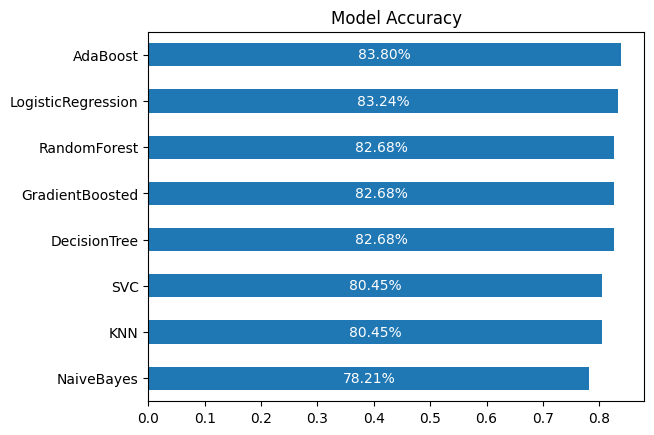

In [389]:
ax = models['Accuracy'].sort_values().plot(kind='barh', title='Model Accuracy')
add_bar_labels(ax, '{:.2%}')
plt.show()

## 5. Evaluation

Through the Titanic data science workflow, several key insights emerged:

- **Survival Rates:** First-class passengers and females had significantly
  higher survival rates. Fare and age also showed notable correlations with
  survival.
- **Feature Engineering:** Extracting titles from names and grouping family
  sizes improved model interpretability and performance.
- **Data Cleaning:** Most columns were clean, with targeted imputation for
  missing ages and embarked locations. Cabin data was largely missing but deck
  extraction provided some value.
- **Modeling:** Multiple models were evaluated using grid search and
  cross-validation. Ensemble methods (Random Forest, Gradient Boosted Trees,
  AdaBoost) generally outperformed simpler models.
- **Best Models:** The highest accuracy was achieved by ensemble tree-based
  models, confirming the value of engineered features and robust preprocessing.

Overall, the workflow demonstrated the importance of thorough data
understanding, careful cleaning, and feature engineering in building effective
predictive models for Titanic survival.

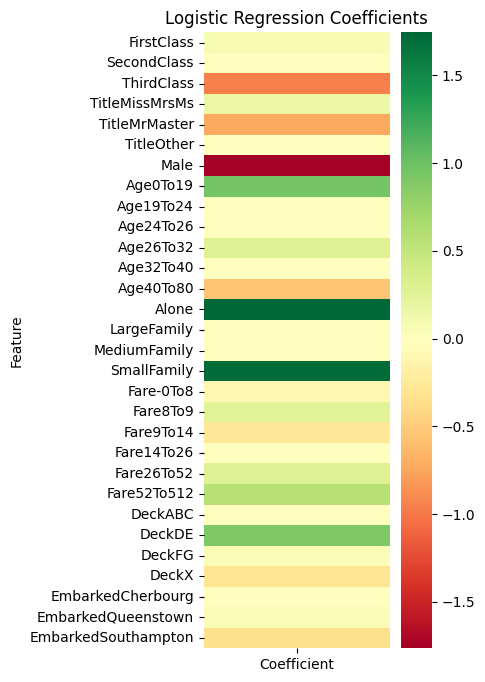

In [425]:
model_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': models.loc['LogisticRegression', 'Model'].coef_[0]
})
model_coefficients.set_index('Feature', inplace=True)

plt.figure(figsize=(3, 8))
sns.heatmap(model_coefficients, cmap='RdYlGn')
plt.title('Logistic Regression Coefficients')
plt.show()